In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import seaborn as sns
import statsmodels.api as sm

In [2]:
filename = "dfa.xlsx"

xl = pd.ExcelFile(filename)
sn = xl.sheet_names
sl = ",\n".join([f"{i} {s}" for i, s in enumerate(sn)])
print(f"Excel file <{filename}> has sheets:\n{sl}")

Excel file <dfa.xlsx> has sheets:
0 descriptions,
1 factors,
2 portfolios (total returns)


  Unnamed: 0            Name           Unit         Construction  \
0     Mkt-RF          Market  Excess Return  Market-cap-weighted   
1        SMB            Size  Excess Return      Small Minus Big   
2        HML           Value  Excess Return       High Minus Low   
3         RF  Risk-free rate   Total Return               Tbills   

                                         Description  
0                                        US Equities  
1             Long small stocks and short big stocks  
2  Long value (high book-to-market) stocks and sh...  
3                                                NaN  


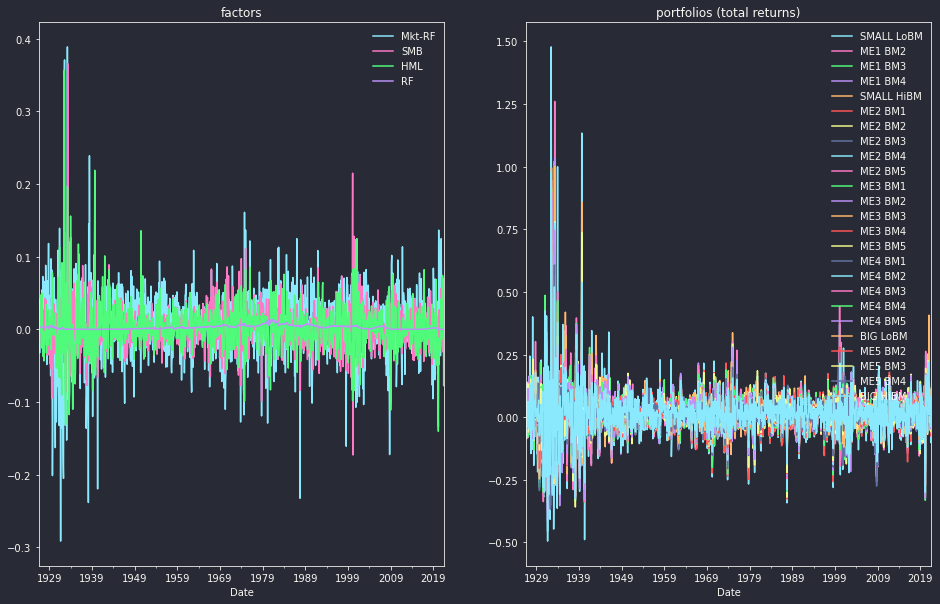

In [3]:
de = xl.parse(sn[0]) # de stands for Descriptions
print(de)
fa = xl.parse(sn[1]) # fa stands for Factors
fa.set_index("Date", inplace=True)
po = xl.parse(sn[2]) # po stands for Portfolios
po.set_index("Date", inplace=True)

fig, axs = plt.subplots(1,2)
fa.plot(ax=axs[0], title=f"{sn[1]}")
po.plot(ax=axs[1], title=f"{sn[2]}")
plt.show()

# 2. The Factors

#### 1. The Factors. Calculate their univariate performance statistics:

• mean

• volatility

• Sharpe

• VaR(.05)

Report these for the following three subsamples:

• Beginning - 1980

• 1981 - 2001

• 2002 - End

In [4]:
def pivot_summaries(data, year_mask, pi=0.05, nper=12):
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    # Build Aggregation Functions here
    def me(x):
        return nper * np.mean(x)
    def sd(x): 
        return np.sqrt(nper) * np.std(x)
    def sr(x):
        return np.sqrt(nper) * np.mean(x) / np.std(x)
    def qt(x):
        return np.quantile(x, pi)
    
    af = [me, sd, sr, qt]
    af_names = ["Mean", "Vol", "Sharpe", f"VaR({pi})"]
    
    pivlist = []
    for start, end in year_mask:
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=af)
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}"] * len(af), af_names],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

miny = str(min(fa.index).year)
maxy = str(max(fa.index).year)

year_mask = [(miny, "1980"), ("1981", "2001"), ("2002", maxy)]

summ = pivot_summaries(fa, year_mask)
summ

year     1926-1980                         1981-2001                           \
measure       Mean    Vol Sharpe VaR(0.05)      Mean    Vol  Sharpe VaR(0.05)   
variable                                                                        
HML         0.0491 0.1337 0.3674   -0.0429    0.0636 0.1110  0.5724   -0.0418   
Mkt-RF      0.0811 0.2049 0.3960   -0.0840    0.0773 0.1571  0.4918   -0.0645   
RF          0.0277 0.0077 3.6176    0.0000    0.0631 0.0077  8.1515    0.0025   
SMB         0.0340 0.1145 0.2967   -0.0434   -0.0005 0.1182 -0.0046   -0.0465   

year     2002-2021                           
measure       Mean    Vol  Sharpe VaR(0.05)  
variable                                     
HML        -0.0117 0.0973 -0.1204   -0.0400  
Mkt-RF      0.0947 0.1505  0.6292   -0.0772  
RF          0.0118 0.0042  2.7865    0.0000  
SMB         0.0238 0.0854  0.2792   -0.0374

#### 2. Based on the factor statistics above, answer the following.

(a) Does each factor have a premium (positive expected excess return) in each subsample?

No, in 1981-2001, SMB had a negative premium, indicating returns less than RF. HML had a negative premium between 2002-2021.

(b) Does the premium to the size factor get smaller after 1980?

Yes, the size factor SMB premium declines from 3.40% to -0.05% in 1981-2001 and 2.38% in 2002-2021.

(c) Does the premium to the value factor get smaller during the 1990’s?

Yes, compared with the 1980's performance, the value factor HML's 1990's performance suffered, declining from 5.90% in the 1980's to -0.11% in the 1990's.

(d) How have the factors performed since the time of the case, (2002-present)?

Market performance has remained consistent throughout the multiple periods tested. The size factor performance was also near its historic levels. However, the value factor saw a significant dropoff in performance, possibly attributed to the expansion of the tech industry driving the performance of growth stocks.

In [5]:
year_mask = [(miny, "1980"), ("1980", maxy), ("1980", "1989"), ("1990", "1999")]

summ2 = pivot_summaries(fa, year_mask)
summ2

year     1926-1980                         1980-2021                          \
measure       Mean    Vol Sharpe VaR(0.05)      Mean    Vol Sharpe VaR(0.05)   
variable                                                                       
HML         0.0491 0.1337 0.3674   -0.0429    0.0217 0.1058 0.2053   -0.0418   
Mkt-RF      0.0811 0.2049 0.3960   -0.0840    0.0885 0.1552 0.5704   -0.0721   
RF          0.0277 0.0077 3.6176    0.0000    0.0400 0.0102 3.9357    0.0000   
SMB         0.0340 0.1145 0.2967   -0.0434    0.0124 0.1037 0.1194   -0.0419   

year     1980-1989                          1990-1999                           
measure       Mean    Vol  Sharpe VaR(0.05)      Mean    Vol  Sharpe VaR(0.05)  
variable                                                                        
HML         0.0590 0.0960  0.6146   -0.0422   -0.0011 0.0913 -0.0118   -0.0405  
Mkt-RF      0.0851 0.1683  0.5055   -0.0648    0.1276 0.1377  0.9269   -0.0494  
RF          0.0855 0.0082 10.4482    0.0043    0.0482 0.0038 12.6079    0.0023  
SMB         0.0012 0.0817  0.0142   -0.0360   -0.0138 0.1032 -0.1332   -0.0515

#### 3. The factors are constructed in such a way as to reduce correlation between them.

Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? Does it achieve this in each subsample?

Yes, the construction of the three factors keeps correlation low throughout the entire 100 year dataset. The highest correlation is between the market and size factor, at 0.32 which is an acceptably low magnitude. However, within the first two subsamples, the value factor HML exhibits relatively high correlations with the market at 0.44 in 1926-1980 and strong negative correlations with the market and size factors -0.53 and -0.45 respectively in 1981-2001. Therefore, the factors may be successful in the long run but may suffer from increased short term correlations.

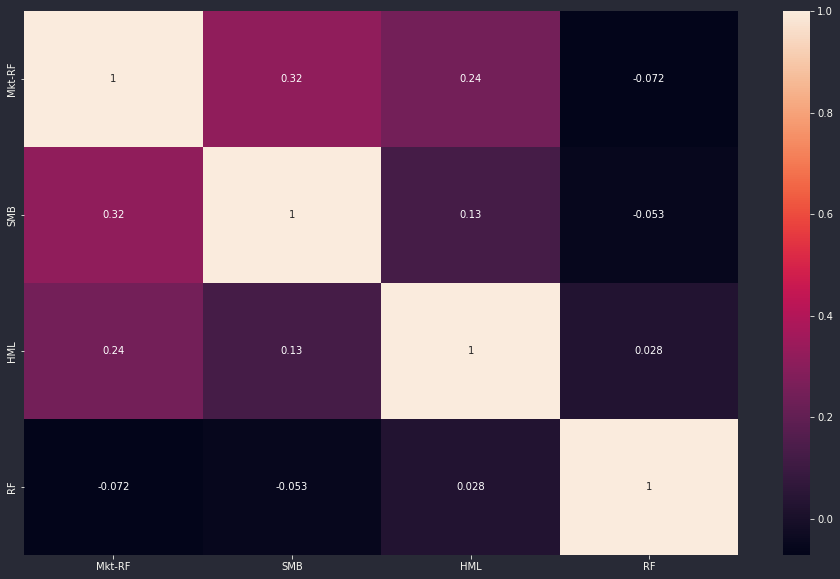

The pair with the HIGHEST correlation is ('Mkt-RF', 'SMB') at 0.31706024978982145
The pair with the LOWEST  correlation is ('Mkt-RF', 'RF') at -0.07152063259457404


In [6]:
def disp_corr(df):
    c = df.corr()
    sns.heatmap(c, annot=True); plt.show()
    
    cu = c.unstack().sort_values(ascending=False)
    cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

    print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max()}")
    print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min()}")

disp_corr(fa)

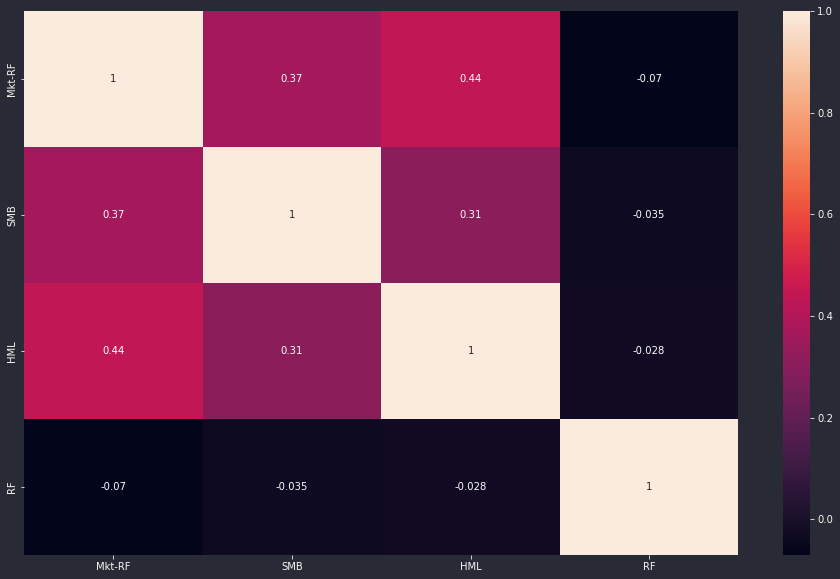

The pair with the HIGHEST correlation is ('Mkt-RF', 'HML') at 0.43863844430419946
The pair with the LOWEST  correlation is ('Mkt-RF', 'RF') at -0.07013419577346959


In [7]:
disp_corr(fa[miny:"1980"])

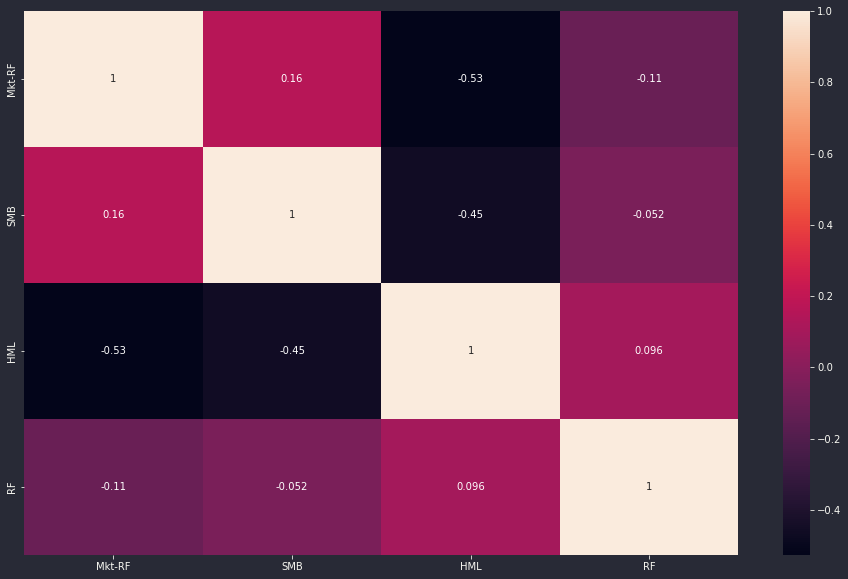

The pair with the HIGHEST correlation is ('Mkt-RF', 'SMB') at 0.1633544504627711
The pair with the LOWEST  correlation is ('Mkt-RF', 'HML') at -0.5263888069285334


In [8]:
disp_corr(fa["1981":"2001"])

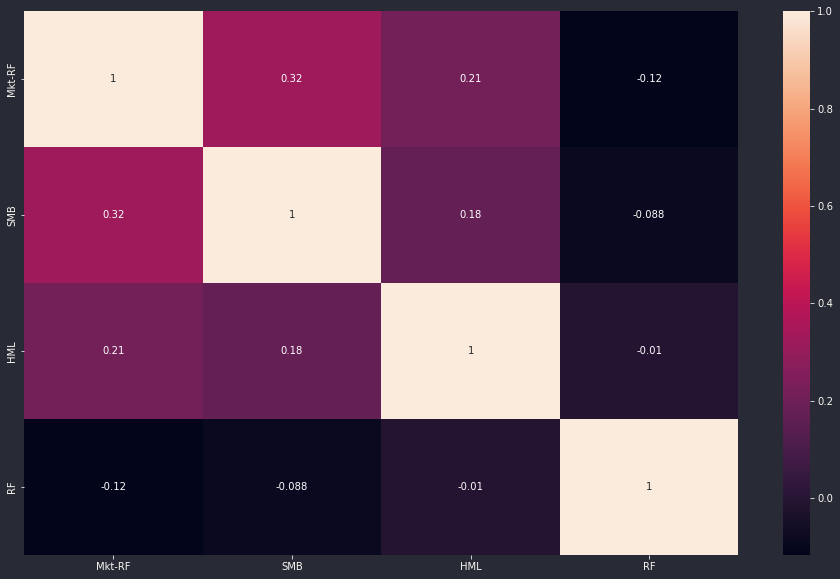

The pair with the HIGHEST correlation is ('Mkt-RF', 'SMB') at 0.3240843105889926
The pair with the LOWEST  correlation is ('Mkt-RF', 'RF') at -0.11593197134806782


In [9]:
disp_corr(fa["2002":maxy])

#### 4. Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

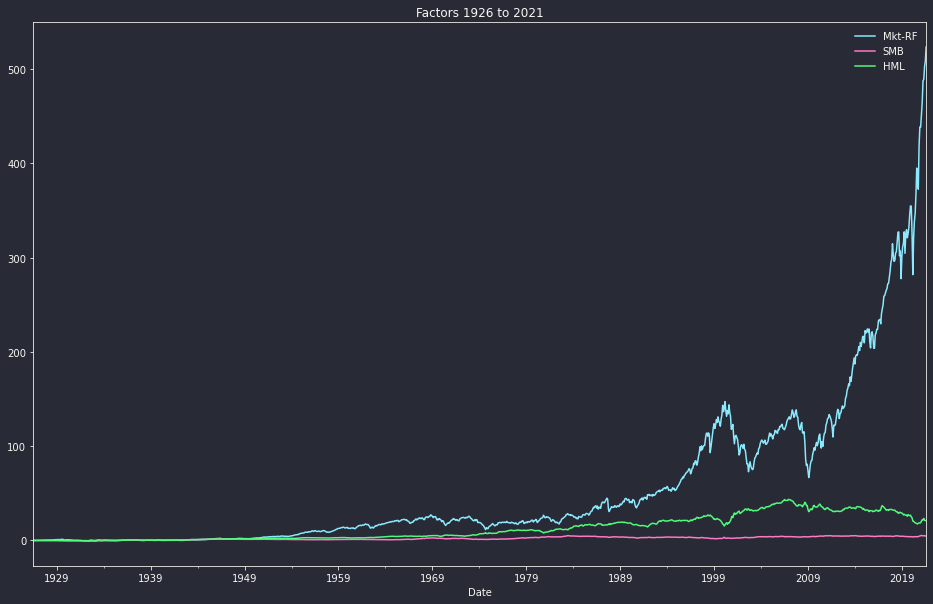

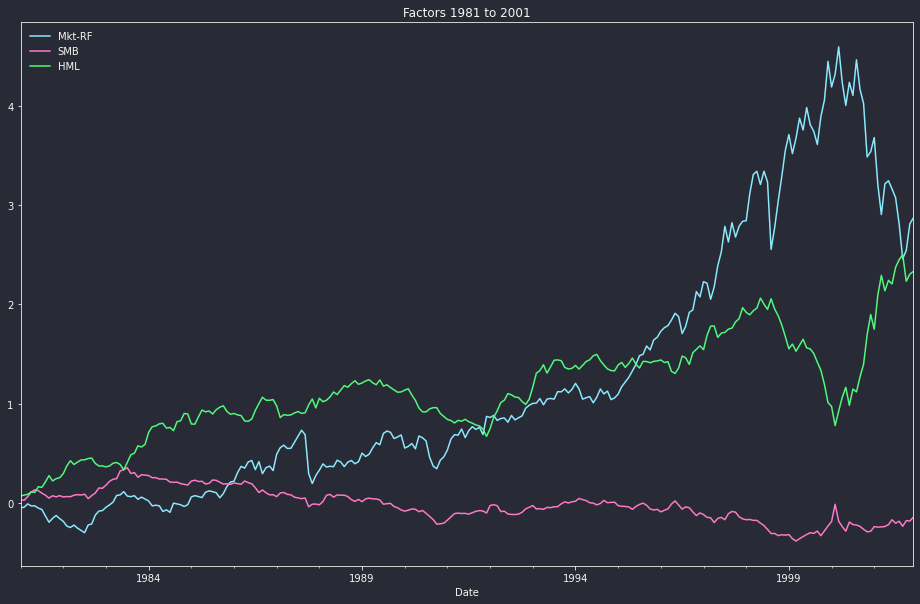

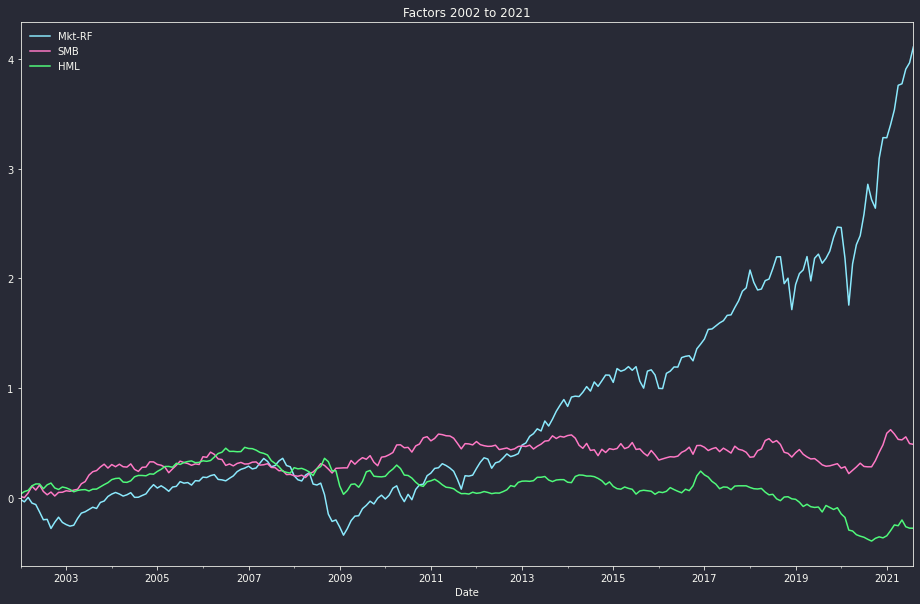

In [10]:
cr = (fa.drop("RF", axis=1)+1).cumprod() - 1

cr.plot(title=f"Factors {miny} to {maxy}"); plt.show()

st = "1981"
ed = "2001"
temp = (fa.loc[st:ed].drop("RF", axis=1)+1).cumprod() - 1
temp.plot(title=f"Factors {st} to {ed}"); plt.show()

st = "2002"
temp = (fa.loc[st:maxy].drop("RF", axis=1)+1).cumprod() - 1
temp.plot(title=f"Factors {st} to {maxy}"); plt.show()

#### 5. Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

The market and value factors exhitited high returns between 1981-2001 whereas the size factor was slightly negative. Post 2001, the market surged forward, leaving both size and value factors significantly behind. Because the value and size factors appear to take distinct paths it does appear that using them as factors may be useful for decomposition.

# 3. CAPM

DFA believes that premia in stocks and stock portfolios is related to the three factors. Let’s test 25 equity portfolios that span a wide range of size and value measures.

• PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as ri, for n = 1, . . . , 25.

• Note that while the factors were given as excess returns, the portfolios are total returns.

• For this entire problem, focus on the 1981-Present subsample.

#### 1. Summary Statistics. For each portfolio,

• Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.

• Calculate the (annualized) univariate statistics from 1.1.

• Can the difference in mean excess returns of the portfolios be explained by differences in
their volatilities? Or by their VaR(.05) statistics?

The differences in the mean excess returns exhibit weak positive correlations with both volatility and VaR. Because the relationship is not especially strong, it would be difficult to infer expected return given either portfolio volatility or VaR.

In [11]:
st = "1981"
po = po.subtract(fa["RF"], axis=0).loc[st:, :]

miny = str(min(po.index).year)
maxy = str(max(po.index).year)
posu = pivot_summaries(po, [("1981", maxy)])
posu

year       1981-2021                        
measure         Mean    Vol Sharpe VaR(0.05)
variable                                    
BIG HiBM      0.0994 0.2054 0.4842   -0.0961
BIG LoBM      0.0944 0.1602 0.5888   -0.0745
ME1 BM2       0.1069 0.2366 0.4517   -0.0940
ME1 BM3       0.0998 0.1972 0.5062   -0.0841
ME1 BM4       0.1248 0.1921 0.6497   -0.0773
ME2 BM1       0.0702 0.2436 0.2882   -0.1036
ME2 BM2       0.1095 0.2016 0.5433   -0.0813
ME2 BM3       0.1099 0.1819 0.6044   -0.0768
ME2 BM4       0.1109 0.1795 0.6179   -0.0777
ME2 BM5       0.1198 0.2118 0.5656   -0.0928
ME3 BM1       0.0807 0.2242 0.3599   -0.0968
ME3 BM2       0.1134 0.1867 0.6076   -0.0793
ME3 BM3       0.0960 0.1697 0.5658   -0.0731
ME3 BM4       0.1123 0.1764 0.6369   -0.0728
ME3 BM5       0.1272 0.1980 0.6425   -0.0798
ME4 BM1       0.1015 0.2022 0.5022   -0.0828
ME4 BM2       0.1001 0.1752 0.5716   -0.0708
ME4 BM3       0.0957 0.1732 0.5525   -0.0757
ME4 BM4       0.1047 0.1728 0.6056   -0.0682
ME4 BM5       0.1111 0.1967 0.5648   -0.0837
ME5 BM2       0.0891 0.1541 0.5783   -0.0654
ME5 BM3       0.0857 0.1522 0.5630   -0.0692
ME5 BM4       0.0667 0.1696 0.3935   -0.0752
SMALL HiBM    0.1343 0.2079 0.6460   -0.0878
SMALL LoBM    0.0222 0.2705 0.0819   -0.1147

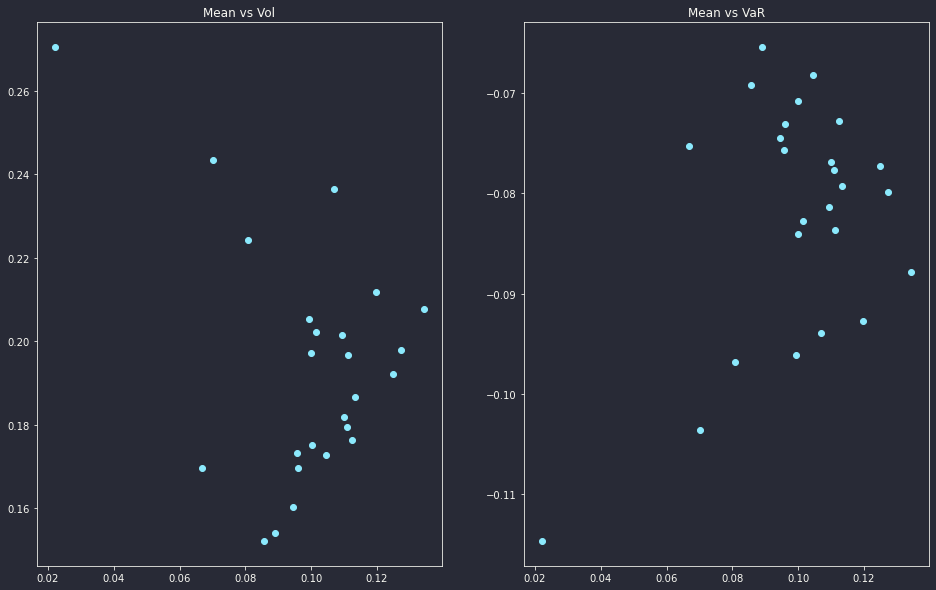

In [12]:
fig, axs = plt.subplots(1,2)

axs[0].scatter(posu[("1981-2021", "Mean")], posu[("1981-2021", "Vol")])
axs[0].set_title("Mean vs Vol")
axs[1].scatter(posu[("1981-2021", "Mean")], posu[("1981-2021", "VaR(0.05)")])
axs[1].set_title("Mean vs VaR")
plt.show()

#### 2. CAPM

The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio’s) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)

Specifically, it asserts that, for any excess return, r ̃ , its mean is proportional to the mean excess mim
return of the market, r ̃ , where the proporitonality is the regression beta of r ̃ on r ̃ .
i i,m m
E[r ̃]=β E[r ̃ ] (CAPM) tt

Let’s examine whether that seems plausible.

(a) For each of the n = 25 test portfolios, run the CAPM time-series regression:
i i i,m m i r ̃ = α + β r ̃ + ε
ttt
So you are running 25 separate regressions, each using the T-sized sample of time-series data.

(b) Report the estimated βi,m, Treynor Ratio, αi, and Information Ratio for each of the n regressions.

(c) If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM were true, alpha would be 0 as all return is driven by the asset's relationship with the market. With 0 alpha, the Information Ratio would also be 0. Treynor Ratio would equal the market return because asset returns are driven beta * market return.

In [13]:
def portstats_bm(v, bm, nper=12):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, tr, ir = [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        alpha.append(res.params[0])
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() * np.sqrt(nper))
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([tr, ir], index=["treynor", "info ratio"], columns=c)
    
    ret = pd.concat([ret, beta, end]).T
    return ret

ps = portstats_bm(po, fa.loc[st:, ["Mkt-RF"]])
ps

,mean,std,sharpe,alpha,beta_Mkt-RF,treynor,info ratio
SMALL LoBM,0.0222,0.2708,0.0818,-0.0079,1.3654,0.0162,-0.5565
ME1 BM2,0.1069,0.2368,0.4513,0.0005,1.1789,0.0906,0.0384
ME1 BM3,0.0998,0.1974,0.5056,0.0008,1.0485,0.0952,0.0880
ME1 BM4,0.1248,0.1923,0.6490,0.0034,0.9789,0.1275,0.3432
SMALL HiBM,0.1343,0.2081,0.6454,0.0040,1.0062,0.1335,0.3464
ME2 BM1,0.0702,0.2438,0.2879,-0.0038,1.3494,0.0520,-0.3571
ME2 BM2,0.1095,0.2018,0.5427,0.0011,1.1293,0.0970,0.1247
ME2 BM3,0.1099,0.1821,0.6037,0.0019,1.0216,0.1076,0.2448
ME2 BM4,0.1109,0.1797,0.6173,0.0023,0.9753,0.1137,0.2777
ME2 BM5,0.1198,0.2120,0.5650,0.0019,1.1253,0.1065,0.1916


#### 3. Cross-sectional Estimation

Let’s test (CAPM) directly. We already have what we need:

• The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.

• The regressor, (x): the market beta from each of the n = 25 time-series regressions. Then we can estimate the following equation:

n×1 data regression intercept n×1 data regression estimate
i i,m
E[r ̃]= η +β; λm + υ

• Note that we use sample means as estimates of E[r ̃i].

• This is a weird regression! The regressors are the betas from the time-series regressions we
already ran!

• This is a single regression, where we are combining evidence across all n = 25 series. Thus, it is a cross-sectional regression!

• The notation is trying to emphasize that the intercept is different than the time-series α and that the regressor coefficient is different than the time-series betas.

(a) Report the R-squared of this regression.

(b) Report the intercept, η.

(c) Report the regression coefficient, λm.

What would these three statistics be if (CAPM) were true?

The $R^2$ would be 1, indicating that mean return is entirely driven by beta. $\eta$ would be 0 because there exists no excess return across all assets. $\lambda_m$ would equal market return.

In [14]:
capm_test = sm.OLS(ps["mean"], sm.add_constant(ps["beta_Mkt-RF"].values)).fit()

e_mkt = fa.loc[st:, "Mkt-RF"].mean() * 12
print(f"The expected regression coefficient is {e_mkt:.4f}")
capm_test.summary()

The expected regression coefficient is 0.0857


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     5.186
Date:                Mon, 25 Oct 2021   Prob (F-statistic):             0.0324
Time:                        16:52:50   Log-Likelihood:                 62.010
No. Observations:                  25   AIC:                            -120.0
Df Residuals:                      23   BIC:                            -117.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1820      0.037      4.987      0.000       0.107       0.258
x1            -0.0775      0.034     -2.277      0.032      -0.148      -0.007
==============================================================================
Omnibus:                        6.106   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                4.206
Skew:                          -0.945   Prob(JB):                        0.122
Kurtosis:                       3.680   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### No Intercept Regression:

In [15]:
capm_test_no = sm.OLS(ps["mean"], ps["beta_Mkt-RF"]).fit()
print(f"The expected regression coefficient is {e_mkt:.4f}")
capm_test_no.summary()

The expected regression coefficient is 0.0857


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   mean   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              268.2
Date:                Mon, 25 Oct 2021   Prob (F-statistic):                    1.58e-14
Time:                        16:52:50   Log-Likelihood:                          52.848
No. Observations:                  25   AIC:                                     -103.7
Df Residuals:                      24   BIC:                                     -102.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
beta_Mkt-RF     0.0911      0.006     16.376      0.000       0.080       0.103
==============================================================================
Omnibus:                       24.078   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.448
Skew:                          -1.985   Prob(JB):                     4.48e-09
Kurtosis:                       7.598   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

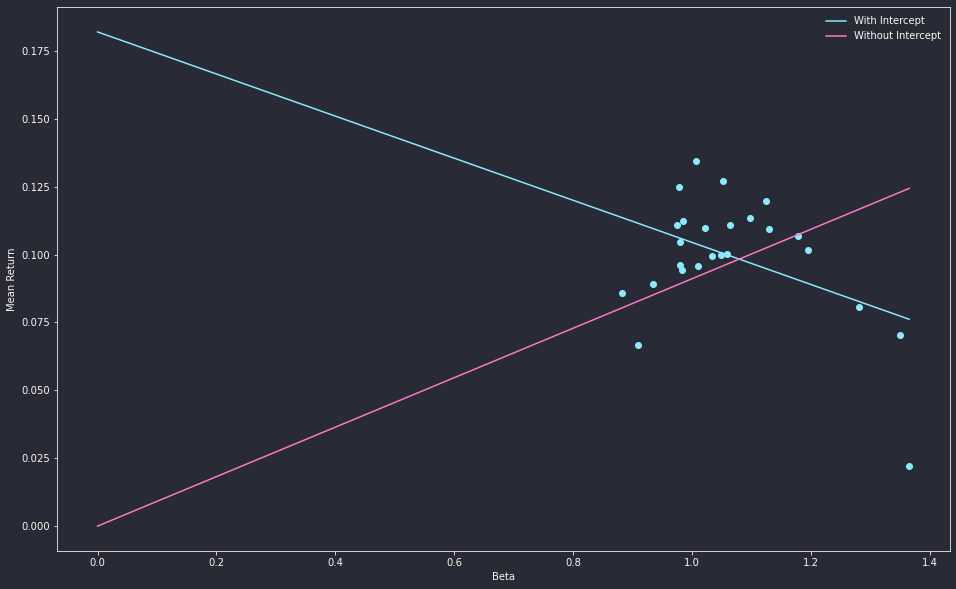

In [16]:
plt.scatter(ps["beta_Mkt-RF"], ps["mean"])

mb = max(ps["beta_Mkt-RF"])
x = [0, mb]
y = [capm_test.params[0], capm_test.params[0]+capm_test.params[1]*mb]
y_no = [0, capm_test_no.params[0] * mb]
plt.plot(x, y, label="With Intercept")
plt.plot(x, y_no, label="Without Intercept")
plt.xlabel("Beta")
plt.ylabel("Mean Return")
plt.legend()
plt.show()

#### 4. Broadly speaking, do these results support DFA’s belief in size and value portfolios containing premia unrelated to the CAPM?



In [17]:
ps = portstats_bm(po, fa.loc["1981":])
ps

,mean,std,sharpe,alpha,beta_Mkt-RF,beta_SMB,beta_HML,beta_RF,treynor,info ratio
SMALL LoBM,0.0222,0.2708,0.0818,-0.0051,1.1208,1.3580,-0.2623,-0.5569,0.0198,-0.6812
ME1 BM2,0.1069,0.2368,0.4513,-0.0003,0.9787,1.3267,-0.0064,0.2953,0.1092,-0.0430
ME1 BM3,0.0998,0.1974,0.5056,-0.0006,0.9328,1.0389,0.2952,0.2003,0.1070,-0.1636
ME1 BM4,0.1248,0.1923,0.6490,0.0019,0.8849,1.0585,0.4812,0.0359,0.1411,0.4759
SMALL HiBM,0.1343,0.2081,0.6454,0.0044,0.9381,1.0566,0.6984,-0.7658,0.1432,0.7087
ME2 BM1,0.0702,0.2438,0.2879,-0.0015,1.1507,1.0034,-0.3276,-0.3357,0.0610,-0.3071
ME2 BM2,0.1095,0.2018,0.5427,0.0007,1.0126,0.8942,0.1358,0.0072,0.1082,0.1738
ME2 BM3,0.1099,0.1821,0.6037,0.0005,0.9757,0.6915,0.4269,0.0374,0.1127,0.1068
ME2 BM4,0.1109,0.1797,0.6173,-0.0005,0.9422,0.7558,0.5797,0.3046,0.1177,-0.1302
ME2 BM5,0.1198,0.2120,0.5650,-0.0001,1.0968,0.9160,0.8069,-0.1319,0.1092,-0.0284
